In [1]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from util.args_parser import parser
from model.QACGBERT import BertConfig
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import (Sentihood_NLI_M_Processor,
                            Semeval_NLI_M_Processor,
                            Persent_Processor)

from util.tokenization import *

from util.evaluation import *

from model.QACGLONG import *

/home/haoyu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df1 = pd.read_csv('../datasets/persent/train_longformer_topic_nocopy.csv')
df2 = pd.read_csv('../datasets/persent/dev_longformer_topic_nocopy.csv')
df3 = pd.read_csv('../datasets/persent/random_test_longformer_topic_nocopy.csv')

df = pd.concat([df1, df2, df3], ignore_index=True)
df.tail()

In [8]:
df_new = df.groupby(by=['group', 'TRUE_SENTIMENT']).count()
df_new.reset_index(inplace=True)
df_new = df_new[['group', 'TRUE_SENTIMENT', 'DOCUMENT_INDEX']]
df_new.columns = ['group', 'sentiment', 'count']

In [37]:
df_new2 = df.groupby(by=['group']).count()
df_new2.reset_index(inplace=True)
df_new2 = df_new2[['group', 'DOCUMENT_INDEX']]
df_new2.columns = ['group', 'count']
df_new2.sort_values(by=['count'], inplace=True)

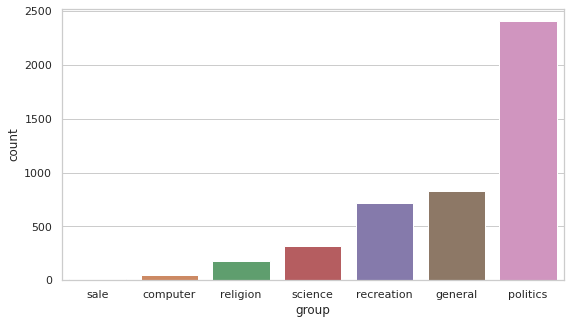

In [42]:
plt.figure(figsize=(9,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='group', y='count', data=df_new2)
plt.show()

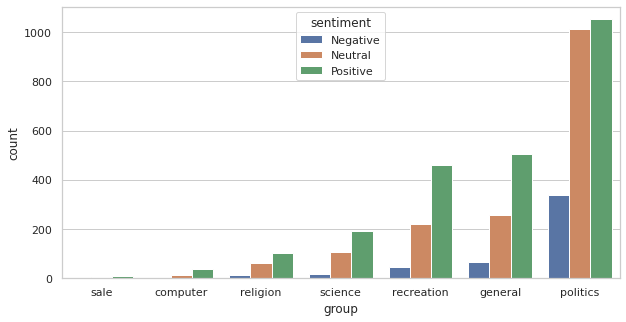

In [43]:
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='group', y='count', data=df_new, hue='sentiment', order=list(df_new2.group))
plt.show()

### Analysis of QACGLONG results

In [3]:
def process_log(data):
    data.reset_index(inplace=True)
    data.drop(['s_auc'], axis=1, inplace=True)
    data.columns = ['epoch', 'global_step', 'loss', 't_loss', 't_acc', 'strict_acc', 'f1', 'auc', 's_acc', 's_auc']
    data.drop(['loss', 'auc', 's_acc', 's_auc'], axis=1, inplace=True)
    data.drop_duplicates(inplace=True)
    return data

In [4]:
data1 = pd.read_csv('../results/persent/7aspects_lr_1e-4+allsamples/7aspects_lr_1e-4+allsamples_noerror_Pretrained_20epoch/log.txt', sep="\t")
data1 = process_log(data1)

# data2 = pd.read_csv('../results/persent/lr_1e-4+7000sample2/log.txt', sep="\t")
# data2 = process_log(data2)

# data3 = pd.read_csv('../results/persent/lr_1e-4+7000sample3/log.txt', sep="\t")
# data3 = process_log(data3)

# data4 = pd.read_csv('../results/persent/lr_1e-4+7000sample4/log.txt', sep="\t")
# data4 = process_log(data4)

# data5 = pd.read_csv('../results/persent/lr_1e-4+7000sample5/log.txt', sep="\t")
# data5 = process_log(data5)

In [47]:
data = pd.concat([data1, data2, data3, data4, data5])

In [48]:
data.to_csv("result.csv", index=False)

In [49]:
df = pd.read_csv("../results/persent/lr_1e-4+7000sample.csv")

In [5]:
df = data1

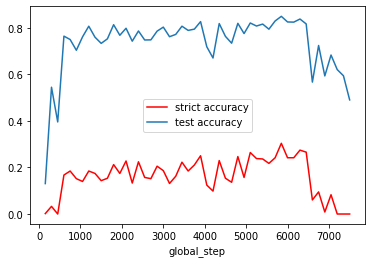

The best otained strict accuracy is 0.3039723661485319
The best otained test accuracy is 0.8497409326424871


In [6]:
sns.lineplot(data=df, x="global_step", y="strict_acc", color="red", label="strict accuracy")
sns.lineplot(data=df, x="global_step", y="t_acc", label="test accuracy")
plt.legend()
plt.ylabel("")
plt.show()

print(f'The best otained strict accuracy is {max(df.strict_acc)}')
print(f'The best otained test accuracy is {max(df.t_acc)}')

## 20 newsgroups trial

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig



In [3]:
data_train = fetch_20newsgroups(subset='train', shuffle=True)
data_test = fetch_20newsgroups(subset='test', shuffle=True)


In [70]:
labels = data_train.target
true_k = np.unique(labels).shape[0]

vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(data_train.data)


In [71]:
target_names = data_train.target_names

y_train, y_test = data_train.target, data_test.target

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(data_test.data)

Extracting features from the test data using the same vectorizer


### logistic regression

In [72]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train.toarray(), y_train)

lr_pred = lr_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, lr_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

lr_pred = lr_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, lr_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")

Train accuracy score: 97.78%
Test accuracy score: 83.32%


### naive bayes

In [73]:
nb_clf = GaussianNB()
nb_clf.fit(X_train.toarray(), y_train)

nb_pred = nb_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, nb_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

nb_pred = nb_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, nb_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")

Train accuracy score: 99.73%
Test accuracy score: 70.91%


### Longformer

In [ ]:
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length=2048)

In [ ]:
train_encodings = tokenizer(data_train.data, truncation=True, padding=True, max_length=2048)
valid_encodings = tokenizer(data_test.data, truncation=True, padding=True, max_length=2048)

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = NewsGroupsDataset(train_encodings, data_train.target)
valid_dataset = NewsGroupsDataset(valid_encodings, data_test.target)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=20, gradient_checkpointing=False, attention_window = 512)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc,}

In [ ]:
training_args = TrainingArguments(
    output_dir = '../results/sentihood/NewsGroups/',
    num_train_epochs =10,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 8,    
    per_device_eval_batch_size=4,
    evaluation_strategy = "steps",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps = 4,
    fp16 = True,
    logging_dir='../results/sentihood/NewsGroups/logs',
    dataloader_num_workers = 0,
    run_name = 'longformer-classification-updated-rtx3090_paper_replication_2_warm'
)

In [ ]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=valid_dataset,          
    compute_metrics=compute_metrics,     
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
model_path = "model/20newsgroups-longformer"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
model = LongformerForSequenceClassification.from_pretrained('model/20newsgroups-longformer', num_labels=20, gradient_checkpointing=False, attention_window = 512)
tokenizer = LongformerTokenizerFast.from_pretrained('model/20newsgroups-longformer', max_length=2048)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


### Obtain prediction from fine-tuned longformer

In [21]:
train_data = pd.read_csv("../datasets/persent/dev_para_nocopy.csv")

In [54]:
target_names = data_train.target_names

def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=2048, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return target_names[probs.argmax()]

def get_max_prob(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=2048, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return max(probs[0].tolist())

In [55]:
train_data['prob_max'] = train_data['DOCUMENT'].apply(get_max_prob)
train_data['topic'] = train_data['DOCUMENT'].apply(get_prediction)


### Map label to 6 groups

In [56]:
topic_groups = {'computer': ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x'], 'recreation': ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'], 'science': ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'], 'sale': ['misc.forsale'], 'politics': ['talk.politics.misc', 'talk.politics.guns', 'talk.politics.mideast'], 'religion': ['talk.religion.misc', 'alt.atheism', 'soc.religion.christian']}
# train_data = pd.read_csv('../datasets/persent/random_test_longformer_topic.csv')

topic_mapping = {}
for key, val in topic_groups.items():
    for sub in val:
        topic_mapping[sub] = key
        
train_data['group'] = train_data['topic'].apply(lambda x: topic_mapping[x])

def group_w_threshold(row):
    if row['prob_max'] <0.5:
        return 'general'
    else:
        return row['group']

train_data['group'] = train_data.apply(group_w_threshold, axis=1)


In [61]:
train_data.to_csv('../datasets/persent/random_test_longformer_topic_nocopy.csv', index=False)

### Select entries from top 4 groups

In [24]:
train_data = train_data.loc[train_data['group'].isin(['politics', 'general', 'recreation', 'science'])]

train_data.reset_index(inplace=True)
train_data.drop(['index'], axis=1, inplace=True)

<ipython-input-24-799753b07265>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['index'], axis=1, inplace=True)


In [63]:
train_data1 = train_data[['DOCUMENT_INDEX', 'TITLE', 'TARGET_ENTITY', 'DOCUMENT', 'MASKED_DOCUMENT']]
train_data1 = train_data1.loc[train_data1.index.repeat(4)]
groups = ['politics', 'general', 'recreation', 'science'] * (train_data1.shape[0] // 4)
train_data1['group'] = groups
train_data1['prob_max'] = np.nan
train_data1['sentiment'] = np.nan
train_data1.reset_index(inplace=True)
train_data1.drop(['index'], axis=1, inplace=True)

for i in range(train_data.shape[0]):
    temp_ind = train_data1.loc[(train_data1['DOCUMENT_INDEX']==train_data['DOCUMENT_INDEX'][i]) & (train_data1['group']==train_data['group'][i])].index[0]
    train_data1.loc[temp_ind, 'sentiment'] = train_data['TRUE_SENTIMENT'][i]
    train_data1.loc[temp_ind, 'prob_max'] = train_data['prob_max'][i]
    
train_data1['sentiment'].fillna('None', inplace=True)



### Create copies (6 rows with another 6 groups and sentiment of None)

In [85]:
train_data1 = train_data[['DOCUMENT_INDEX', 'TITLE', 'TARGET_ENTITY', 'DOCUMENT', 'MASKED_DOCUMENT']]
train_data1 = train_data1.loc[train_data1.index.repeat(7)]
groups = ['politics', 'recreation', 'computer', 'religion', 'science', 'sale', 'general'] * (train_data1.shape[0] // 7)
train_data1['group'] = groups
train_data1['prob_max'] = np.nan
train_data1['sentiment'] = np.nan
train_data1.reset_index(inplace=True)
train_data1.drop(['index'], axis=1, inplace=True)

for i in range(train_data.shape[0]):
    temp_ind = train_data1.loc[(train_data1['DOCUMENT_INDEX']==train_data['DOCUMENT_INDEX'][i]) & (train_data1['group']==train_data['group'][i])].index[0]
    train_data1.loc[temp_ind, 'sentiment'] = train_data['TRUE_SENTIMENT'][i]
    train_data1.loc[temp_ind, 'prob_max'] = train_data['prob_max'][i]
    
train_data1['sentiment'].fillna('None', inplace=True)




In [65]:
train_data1['context'] = '[TGT] - '+ train_data1['group']


In [67]:
train_data1.to_csv('../datasets/persent/random_test_longformer_4topics.csv', index=False)

## Partial Trial Run

In [2]:
%env CUDA_VISIBLE_DEVICES=1,4,5,8 CUDA_LAUNCH_BLOCKING=1

env: CUDA_VISIBLE_DEVICES=1,4,5,8 CUDA_LAUNCH_BLOCKING=1


In [3]:
processors = {
    "sentihood_NLI_M":Sentihood_NLI_M_Processor,
    "semeval_NLI_M":Semeval_NLI_M_Processor,
    "persent":Persent_Processor
}

In [4]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

def system_setups(args):
    # system related setups
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        n_gpu = torch.cuda.device_count()
    else:
        device = torch.device("cuda", args.local_rank)
        n_gpu = 1
        # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.distributed.init_process_group(backend='nccl')
    logger.info("device %s n_gpu %d distributed training %r", device, n_gpu, bool(args.local_rank != -1))

    if args.accumulate_gradients < 1:
        raise ValueError("Invalid accumulate_gradients parameter: {}, should be >= 1".format(
                            args.accumulate_gradients))

    args.train_batch_size = int(args.train_batch_size / args.accumulate_gradients)

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if args.bert_config_file is not None:
        bert_config = BertConfig.from_json_file(args.bert_config_file)
        if args.max_seq_length > bert_config.max_position_embeddings:
            raise ValueError(
                "Cannot use sequence length {} because the BERT model was only trained up to sequence length {}".format(
                args.max_seq_length, bert_config.max_position_embeddings))

    # not preloading
    if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    os.makedirs(args.output_dir, exist_ok=True)

    output_log_file = os.path.join(args.output_dir, "log.txt")
    print("output_log_file=",output_log_file)

    if args.task_name == "sentihood_NLI_M":
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\tstrict_acc\tf1\tauc\ts_acc\ts_auc\n")
    elif args.task_name == "semeval_NLI_M":
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\taspect_P\taspect_R\taspect_F\ts_acc_4\ts_acc_3\ts_acc_2\n")
    else:
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\tstrict_acc\tf1\tauc\ts_acc\ts_auc\n")

    return device, n_gpu, output_log_file

In [5]:
args_init = ['--task_name', 'persent', 
             '--data_dir', '../datasets/persent/',
             '--output_dir', '../results/persent/QACGLONG-reproduce/',
             '--model_type', 'QACGLONG',
             '--do_lower_case',
             '--max_seq_length', '2048',
             '--train_batch_size', '64',
             '--eval_batch_size', '12',
             '--learning_rate', '1e-4',
             '--num_train_epochs', '10',
             '--vocab_file', 'BERT-Google/vocab.txt',
             '--bert_config_file', 'Longformer/config.json',
             '--init_checkpoint', '../results/persent/4aspects_no_error_evaluation/lr_1e-4+allSamples/checkpoint_2940.bin', 
             '--seed', '123',
             '--evaluate_interval', '80',
             '--accumulate_gradients', '8',
             '--gradient_accumulation_steps', '8']

args = parser.parse_args(args_init)

In [6]:
device, n_gpu, output_log_file= system_setups(args)

07/20/2022 21:30:28 - INFO - __main__ -   device cuda n_gpu 1 distributed training False


output_log_file= ../results/persent/QACGLONG-reproduce/log.txt


In [8]:
from transformers import LongformerTokenizer

def getModelOptimizerTokenizer(model_type, vocab_file,
                               bert_config_file=None, init_checkpoint=None,
                               label_list=None,
                               do_lower_case=True,
                               num_train_steps=None,
                               learning_rate=None,
                               base_learning_rate=None,
                               warmup_proportion=None,
                               init_lrp=False):

    # this is the model we develop
    tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
#     tokenizer = FullTokenizer(
#         vocab_file=vocab_file, do_lower_case=do_lower_case, pretrain=False)
    if bert_config_file is not None:
        bert_config = BertConfig.from_json_file(bert_config_file)
    else:
        # default?
        print("else implemented")
        bert_config = BertConfig(
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=512,
            type_vocab_size=2,
            initializer_range=0.02
        )
    logger.info("*** Model Config ***")
    logger.info(bert_config.to_json_string())
    # overwrite the vocab size to be exact. this also save space incase
    # vocab size is shrinked.
#     bert_config.vocab_size = len(tokenizer.vocab)
    bert_config.vocab_size = tokenizer.vocab_size
    # model and optimizer
    logger.info("model = QACGLONG")
    model = QACGBertForSequenceClassification1(
                    bert_config, len(label_list),
                    init_weight=True,
                    init_lrp=init_lrp)

    if init_checkpoint is not None:
        print(init_checkpoint)
        logger.info("retraining with saved model.")
        # only load fields that are avaliable
        model.bert.load_state_dict(torch.load(init_checkpoint, map_location='cpu'), strict=False)
    no_decay = ['bias', 'gamma', 'beta']
    block_list = []
    
    optimizer_parameters = [
        {'params': [p for n, p in model.named_parameters() 
            if not any(nd in n for nd in no_decay) and not any(bl in n for bl in block_list)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in model.named_parameters() 
            if any(nd in n for nd in no_decay) and not any(bl in n for bl in block_list)], 'weight_decay_rate': 0.0}
        ]

    optimizer = BERTAdam(optimizer_parameters,
                        lr=learning_rate,
                        warmup=warmup_proportion,
                        t_total=num_train_steps)
    return model, optimizer, tokenizer

In [ ]:
processor = processors[args.task_name]()
label_list = processor.get_labels()

# training setup
train_examples = None
num_train_steps = None
train_examples = processor.get_train_examples(args.data_dir)
num_train_steps = int(len(train_examples) / args.train_batch_size * args.num_train_epochs)

# model and optimizer
model1, optimizer, tokenizer = getModelOptimizerTokenizer(model_type=args.model_type,
                                   vocab_file=args.vocab_file,
                                   bert_config_file=args.bert_config_file,
                                   init_checkpoint=args.init_checkpoint,
                                   label_list=label_list,
                                   do_lower_case=True,
                                   num_train_steps=num_train_steps,
                                   learning_rate=args.learning_rate,
                                   base_learning_rate=args.base_learning_rate,
                                   warmup_proportion=args.warmup_proportion)

In [10]:
# context_id_map_persent = {'[TGT] - politics': 0,
#                           '[TGT] - recreation': 1,
#                           '[TGT] - computer': 2,
#                           '[TGT] - religion': 3,
#                           '[TGT] - science': 4,
#                           '[TGT] - sale': 5,
#                           '[TGT] - general': 6}

context_id_map_persent = {'[TGT] - politics': 0,
                          '[TGT] - general': 1,
                          '[TGT] - recreation': 2,
                          '[TGT] - science': 3}

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, seq_len,
                 context_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.seq_len = seq_len
        # extra fields to hold context
        self.context_ids = context_ids

def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, max_context_length,
                                 # if this is true, the context will not be
                                 # appened into the inputs
                                 context_standalone, args):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(tqdm(examples)):
        temp = example.text_a
        tokens_a = tokenizer.tokenize(temp)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
        # tokens of context
        tokens_context = None
        if example.text_b:
            tokens_context = tokenizer.tokenize(example.text_b)
            
        if args.task_name != 'persent':
            text_a_new = temp * ((2045 - len(tokens_b)) // len(tokens_a))
            tokens_a = tokenizer.tokenize(text_a_new)

        if tokens_b and not context_standalone:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b and not context_standalone:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        context_ids = []
        if tokens_context:
            # let us encode context into single int
            if args.task_name == "sentihood_NLI_M":
                context_ids = [context_id_map_sentihood[example.text_b]]
            elif args.task_name == "semeval_NLI_M":
                context_ids = [context_id_map_semeval[example.text_b]]
            else:
                context_ids = [context_id_map_persent[example.text_b]]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        seq_len = len(input_ids)
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        while len(context_ids) < max_context_length:
            context_ids.append(0)
            
        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(context_ids) == max_context_length

        label_id = label_map[example.label]

        features.append(
                InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_id=label_id,
                        seq_len=seq_len,
                        # newly added context part
                        context_ids=context_ids))
    
    return features

In [12]:
# training set
train_features = convert_examples_to_features(
        train_examples, label_list, args.max_seq_length,
        tokenizer, args.max_context_length,
        args.context_standalone, args)

100%|██████████| 23485/23485 [01:51<00:00, 210.94it/s]


In [11]:
# test set
test_examples = processor.get_combo_examples(args.data_dir)
test_features = convert_examples_to_features(
        test_examples, label_list, args.max_seq_length,
        tokenizer, args.max_context_length,
        args.context_standalone, args)

100%|██████████| 4312/4312 [00:13<00:00, 327.27it/s]


In [12]:
input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)
context_ids = torch.tensor([f.context_ids for f in test_features], dtype=torch.long)

In [13]:
test_data = TensorDataset(input_ids, input_mask, segment_ids,
                                label_ids, seq_len, context_ids)
test_dataloader = DataLoader(test_data, batch_size=args.eval_batch_size, shuffle=False)

In [13]:
max_seq_lens = max(seq_len)[0]
input_ids = input_ids[:,:max_seq_lens]
input_mask = input_mask[:,:max_seq_lens]
segment_ids = segment_ids[:,:max_seq_lens]


input_ids = input_ids.to(device)
input_mask = input_mask.to(device)
segment_ids = segment_ids.to(device)
label_ids = label_ids.to(device)
seq_len = seq_len.to(device)
context_ids = context_ids.to(device)

In [ ]:
model1.to(device)

In [ ]:
tmp_test_loss, logits, _, _, _, _ = model1(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_mask, seq_lens=seq_len, device=device, labels=label_ids, context_ids=context_ids)
